### Calculates adjusted stock returns

#### Given raw unadjusted stock prices and history on dividend, split and bonus, this notebook calculates adjusted stock prices.
+ Examples used in this demo : WIPRO,TCS and INFOSYS

In [1]:
import datetime
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.finance as finance
import matplotlib.dates as mdates
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
'''
Plot stock chart for the given series.
'''
def plot_stock_chart(price_series, color = 'green', stock_name = ''):
    plt.rc('axes', grid=True)
    plt.rc('grid', color='0.75', linestyle='-', linewidth=0.5)
    rect = [0.4, 0.5, 0.8, 0.5]

    fig = plt.figure(facecolor='white', figsize=(16,12))
    ax = fig.add_axes(rect, axisbg='#f6f6f6')

    ax.plot(price_series.index, price_series.values, color = color, lw = 2, label = stock_name)
    ax.legend(loc='upper right', shadow=True, fancybox=True)

    for label in ax.get_xticklabels():
        label.set_rotation(30)
        label.set_horizontalalignment('right')

    ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

    plt.show()
    
'''
Price History holds price data for the stock.
'''    
class Price_History:

    def __init__(self, price_data):
        self.price_data = price_data.copy()
        self.price_data['adjusted_price'] = self.price_data['Close Price']
        self.price_data['adjustment_event'] = ''        
        
    def get_price_history(self):
        return self.price_data
        
    def adjust_price(self,adjustment_data):
        adjustment_data = adjustment_data.sort_index()
        
        for event_date,adjustment_factor,adjustment_event in adjustment_data[['adjustment_factor','adjustment_event']].itertuples():
            if event_date in self.price_data.index:
                self.price_data.loc[self.price_data.index < event_date,'adjusted_price'] = self.price_data.loc[self.price_data.index < event_date,'adjusted_price']/adjustment_factor
                self.price_data.set_value(event_date,'adjustment_event',adjustment_event)
            else:
                print 'Event date %s not found' % str(event_date)
        
        return self.price_data    

In [3]:
STOCK_NAME = 'INFY'
# Raw Stock prices : Available on BSE or Yahoo
raw_price_data = pd.read_csv('data\\INFY.csv', index_col = 0, parse_dates = True,usecols = ['Date','Close Price'],dtype= {'Close Price':np.float64})
raw_price_data = raw_price_data.sort_index()

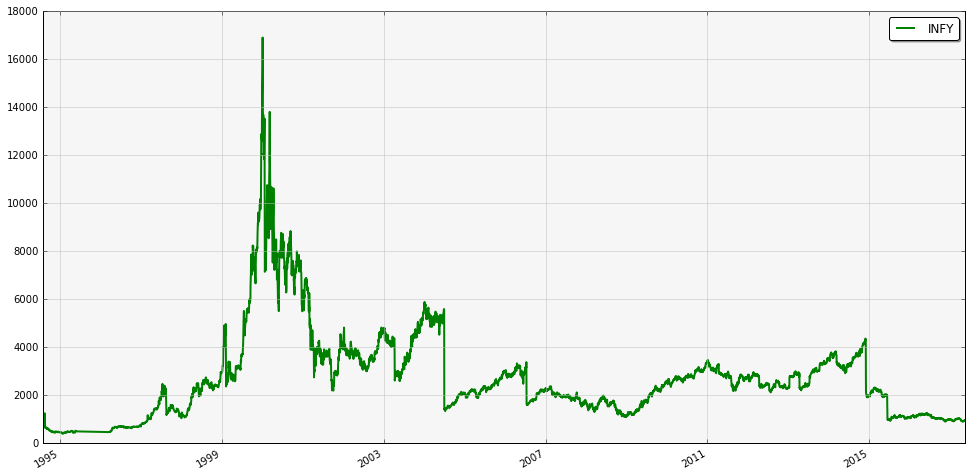

In [4]:
plot_stock_chart(raw_price_data['Close Price'],'green',STOCK_NAME)

In [5]:
#Stock Split data
stock_split_data = pd.read_csv('data\\INFY_Split.csv',index_col = 4, parse_dates = True )
stock_split_data['adjustment_factor'] = stock_split_data['Old FV']/stock_split_data['New FV']
stock_split_data['adjustment_event']  = 'Split'

#Stock Bonus data
stock_bonus_data = pd.read_csv('data\\INFY_Bonus.csv',index_col = 4, parse_dates = True )
stock_bonus_data['adjustment_factor'] = stock_bonus_data['New Holding']/stock_bonus_data['Old Holding']                                
stock_bonus_data['adjustment_event']  = 'Bonus'

#Stock dividend data
dividend_data = pd.read_csv('data\\INFY_dividend.csv', index_col = 1,parse_dates = True)
dividend_data = dividend_data.merge(raw_price_data, left_index=True, right_index=True, how='left')
dividend_data['adjustment_factor'] = (dividend_data['Close Price'] +  dividend_data['Dividend per share'])/dividend_data['Close Price']
dividend_data['adjustment_event']  = 'Dividend'

#Dividend Reinvestement
div_rein_data = dividend_data.loc[:,['Dividend per share','Close Price','adjustment_event']]
div_rein_data['adjustment_factor'] = 1 + (div_rein_data['Dividend per share']/div_rein_data['Close Price'])

In [8]:
#Calculate adjusted returns
price_history = Price_History(raw_price_data)        
price_history.adjust_price(stock_split_data)
price_history.adjust_price(stock_bonus_data)                
price_history.adjust_price(dividend_data)
adjusted_data = price_history.adjust_price(div_rein_data)

Event date 2017-06-01 00:00:00 not found
Event date 2017-06-01 00:00:00 not found


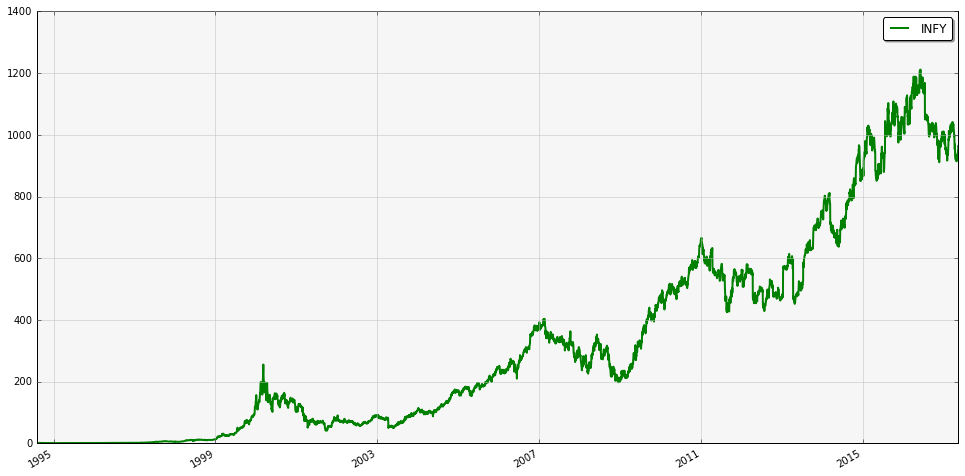

In [9]:
plot_stock_chart(adjusted_data['adjusted_price'],'green',STOCK_NAME)